<a href="https://colab.research.google.com/github/viraj-sampat/vwm_research/blob/main/square_image_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torchvision
from torchvision import transforms
from IPython.display import IFrame
from IPython.display import display_pdf
from IPython.display import FileLink
from IPython.display import display
import os
from google.colab import drive
import scipy
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Import Data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = torch.load(f'/content/drive/MyDrive/Research/square_images.pt')

In [ ]:
training_data, test_data = train_test_split(data, test_size=0.30, shuffle = True)

In [ ]:
#batch_size = len(training_data)
#train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle = False)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000-batch_size, shuffle = False)

# Visualize Data

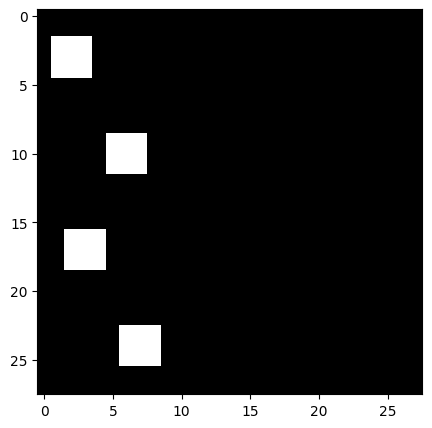

In [ ]:
# obtain one batch of training images
#dataiter = iter(train_loader)
#images = next(dataiter)
#images = images.numpy()

# get one image from the batch
#img = np.squeeze(images[0])
img = np.squeeze(training_data[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Create Models (Regular and Noisy)

In [ ]:
class MNISTAutoencoder(nn.Module):
    def __init__(self):
        super(MNISTAutoencoder, self).__init__()
        
        output_channels = 1
        kernel_size = 4
        self.encoding_dimension = 4
        self.encoder = nn.Sequential(
            nn.Conv2d(1, output_channels, kernel_size = kernel_size),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(output_channels*((28-kernel_size+1)**2), self.encoding_dimension),
            #nn.ReLU(True)
            nn.Sigmoid()
            )
        self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dimension, output_channels*((28-kernel_size+1)**2)),
            nn.ReLU(True),
            nn.Unflatten(1, (output_channels, 28-kernel_size+1, 28-kernel_size+1)),
            nn.ConvTranspose2d(output_channels, 1, kernel_size = kernel_size),
            nn.Sigmoid()
            )
        
    def add_noise(self, x):
        num_discrete = int(self.encoding_dimension/2)
        std = 0.5
        x[:,0:num_discrete] = x[:,0:num_discrete] + torch.randn(len(x), num_discrete)*std
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = torch.atan(x)
        #x = self.add_noise(x.clone())
        x = torch.tan(x)
        x = self.decoder(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MNISTAutoencoder().to(device)

# Initialize Loss and Optimizer

In [ ]:
#loss_function = torch.nn.MSELoss()
#loss_function = F.binary_cross_entropy
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9)

# Train Model

In [ ]:
num_epochs = 10
print('Training Model...')
for epoch in range(num_epochs):
    training_loss = 0.0
    #for data in training_data:
    for data in training_data:
        image = data
        image = torch.unsqueeze(image,0) # add extra dimension at 0
        image = image.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_function(output.flatten(), image.flatten())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    print('Epoch {}/{}, Loss: {:.4f}'.format(epoch+1, num_epochs, training_loss/len(training_data)))
        
        

Training Model...
Epoch 1/10, Loss: 0.1696
Epoch 2/10, Loss: 0.1310
Epoch 3/10, Loss: 0.1194
Epoch 4/10, Loss: 0.1131
Epoch 5/10, Loss: 0.1095
Epoch 6/10, Loss: 0.1072
Epoch 7/10, Loss: 0.1056
Epoch 8/10, Loss: 0.1045
Epoch 9/10, Loss: 0.1036
Epoch 10/10, Loss: 0.1029


regular model results...


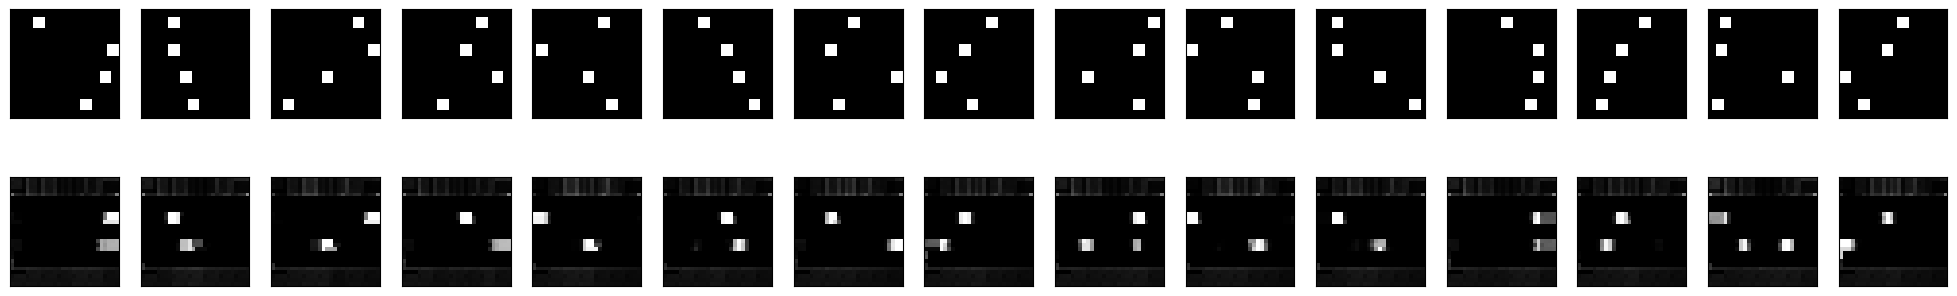

In [ ]:
print('regular model results...')
#dataiter = iter(test_loader)
#images = next(dataiter)
images = test_data
# get sample outputs
#outputs = model(test_data)
outputs = model(images)
# prep images for display
#images = images.numpy()
enc = model.encoder(test_data)
#enc = model.encoder(images)

# output is resized into a batch of images
outputs = outputs.view(len(test_data), 1, 28, 28)
#outputs = outputs.view(1000-batch_size, 1, 28, 28)

outputs = outputs.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=15, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, outputs], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# x = enc[:,0].detach()
# y = enc[:,1].detach()
# z = enc[:,2].detach()
# colormap = np.array(['r', 'g', 'b', 'c', 'm', 'y','magenta','yellow', 'orange', 'k'])
# ax.scatter(x,y,z, c = colormap[labels])
# ax.set_xlabel("Dim 1") 
# ax.set_ylabel("Dim 2") 
# ax.set_zlabel("Dim 3")
# plt.show()
# output.disable_custom_widget_manager()
